In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [4]:
# CSV einlesen (nur relevante Spalten behalten)
data = pd.read_csv("realtor-data.zip.csv")

# Zufällige 500k Zeilen ziehen
data = data.sample(n=500_000, random_state=7)

print("Shape nach Sampling:", data.shape)


Shape nach Sampling: (500000, 12)


In [5]:
print("Shape vor Bereinigung:", data.shape)
print(data.isna().sum())   # Anzahl fehlender Werte pro Spalte

Shape vor Bereinigung: (500000, 12)
brokered_by         1039
status                 0
price                366
bed               108197
bath              115098
acre_lot           73298
street              2501
city                 338
state                  2
zip_code              71
house_size        127825
prev_sold_date    165350
dtype: int64


In [6]:
# Duplikate entfernen
data = data.drop_duplicates()
print("Shape nach Duplikat-Entfernung:", data.shape)


Shape nach Duplikat-Entfernung: (500000, 12)


In [7]:
# Strings auffüllen
for col in ["brokered_by", "status", "street", "city", "state", "zip_code", "prev_sold_date"]:
    if col in data.columns:
        data[col] = data[col].fillna("Unknown")

# Numerische Spalten auffüllen
num_cols = data.select_dtypes(include=[np.number]).columns
for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

print("Fehlwerte nach Behandlung:", data.isna().sum().sum())


Fehlwerte nach Behandlung: 0


In [8]:
# Zielvariable (Hauspreis)
y = data["price"].values

# Features (z. B. ohne ID, Adresse, State etc.)
X = data.drop(columns=[
    "price",        # Target
    "status",       # String
    "brokered_by",  # String
    "street",       # String
    "city",         # String
    "state",        # String
    "zip_code",     # Kategorie -> erstmal weg
    "prev_sold_date"  # Datum -> erstmal weg
]).values

# Log-Transformation auf Zielvariable
y = np.log1p(y)  # log(1+y), verhindert Probleme mit 0-Werten


In [9]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Skalierung nur auf Training fitten
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
model2 = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)  # Regression Output
])

model2.compile(optimizer="adam", loss="mse", metrics=["mae"])
model2.summary()


d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model2.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    verbose=1
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 24.1872 - mae: 1.5141 - val_loss: 1.3326 - val_mae: 0.7465
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6180 - mae: 0.8755 - val_loss: 1.1006 - val_mae: 0.7390
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.6376 - mae: 0.8400 - val_loss: 1.0151 - val_mae: 0.7293
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3559 - mae: 0.7999 - val_loss: 0.9983 - val_mae: 0.7225
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1320 - mae: 0.7627 - val_loss: 1.0182 - val_mae: 0.7158
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4990 - mae: 0.7620 - val_loss: 0.9791 - val_mae: 0.7203
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0258 - mae: 0.7339 - val_loss: 0.9764 - val_mae: 0.7129
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0690 - mae: 0.7324 - val_loss: 1.0044 - val_mae: 0.7145
Epoch 9/50
1250/1250 ━━━━━━━━━━━━━━━━━━

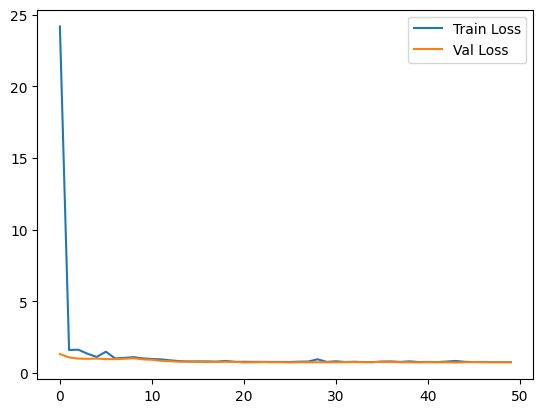

In [12]:
# Trainingskurve visualisieren
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [13]:
# Vorhersagen machen
y_pred = model2.predict(X_test).flatten()

# Rücktransformation vom log
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

# Metriken
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 659us/step
R² Score: -0.3705780674732322
MAE: 289762.97389077523
MSE: 1705928117273.7446
RMSE: 1306111.8318404993


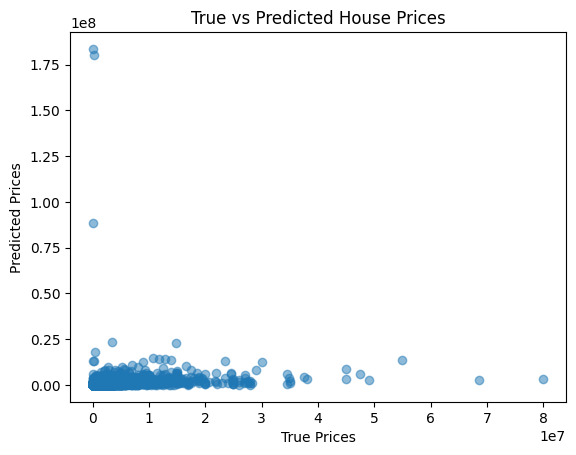

In [14]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("True vs Predicted House Prices")
plt.show()


In [15]:
# Beispiel: Neuen Datensatz vorhersagen
new_data = np.array([X_test[0]])  # erster Testwert
new_data_scaled = scaler.transform(new_data)

predicted_price = np.expm1(model2.predict(new_data_scaled)[0][0])
print("Predicted price:", predicted_price)
print("True price:", np.expm1(y_test[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted price: 166450.94
True price: inf


C:\Users\Timothy\AppData\Local\Temp\ipykernel_13036\3369897934.py:7: RuntimeWarning: overflow encountered in expm1
  print("True price:", np.expm1(y_test[0]))
